In [1]:
# Stop showing warnings
using Suppressor: @suppress_err

In [2]:
using Clustering
using MultivariateStats
using StatsBase
using CSV
using DataFrames
using CairoMakie
using GaussianMixtures

In [3]:
function ground_true(df_1, df_2)
    a = fill(1,nrow(df_1))
    b = fill(2,nrow(df_2))
    gt = cat(a,b, dims = 1)
    return gt
end

# convert tree from dataframe to matrix. Each column is a tree
function standardize_tree(tree)    
    data = collect(Matrix(tree[:,:])');
    
    # standardize tree
    dt = fit(ZScoreTransform, data, dims=2)
    data = StatsBase.transform(dt, data)
    
    # replace NaN value with 0
    replace!(data, NaN=>0)
    return data
end

function plot_clusters(tree, label)
    PCA_model = fit(PCA, tree, maxoutdim = 2);
    PCA_data = predict(PCA_model,tree)
    scatter(PCA_data[1,:], PCA_data[2,:], markersize = 5, color = label)
end

plot_clusters (generic function with 1 method)

In [4]:
using MLBase
using Hungarian
using LinearAlgebra

In [5]:
# n is the number of cluters
# remember standardize trees for better performance
function kmeans_label(tree, n; seed =:kmpp)  
    # apply kmeans clustering
    # init works like seed of random, Its length should be the same as the number of clusters    
    result = kmeans(tree, n, init = seed);
    return result.assignments
end;


function GMM_label(tree, n; method=:kmeans, kind=:diag)    
    data= tree';
    gmm=GMM(n,Array(data),method=method, kind=kind);
    prob_pos=gmmposterior(gmm,Array(data))[1]
    llpg = gmmposterior(gmm,Array(data))[2]
    llpg_result = map(argmin, eachrow(llpg))
    prob_result = map(argmax, eachrow(prob_pos))
    return Pair(llpg_result, prob_result)
end;

function dbscan_label(tree, radius; min_neighbors = 1, min_cluster_size = 1)   
    result = dbscan(tree, radius,min_neighbors = min_neighbors, min_cluster_size = min_cluster_size)   
    # get only points in clusters
    result = getproperty.(result, :core_indices)
    idx = fill(0,length(tree[1,:]))
    for i in range(1, length(idx))
        if i in result[1]
            idx[i] = 1
        elseif i in result[2]
            idx[i] = 2
        end
    end
    return idx
end;
# Performance Check

function accuracy(n, gt, pred)
    matrix = confusmat(n, gt, pred)
    # Hungarian algorithm minimizes the cost, so we need to transform the matrix
    A = -matrix .+ maximum(matrix)    
    matrix = matrix[:,hungarian(A)[1]]
    x = tr(matrix)/sum(matrix)
    return matrix, x
end

accuracy (generic function with 1 method)

In [12]:
trees = []
for i in 1:15
    path = "data/4_taxa_" * string(i) *"_1_100.csv"
    tree = CSV.read(path, DataFrame);
    push!(trees, tree)
end

In [7]:
# Kmeans
function kmeans_matrix(trees, path)
    n = length(trees)
    result = zeros(n, n)
    for i in 1:n
        if i == 1
            continue
        end
        for j in  1:(i - 1)
            gt = ground_true(trees[i],trees[j])
            tree = vcat(trees[i],trees[j])
            tree = standardize_tree(tree)
            pred_kmeans = kmeans_label(tree, 2)
            m,x = accuracy(2, gt, pred_kmeans)
            result[i,j] = x
            result[j,i] = x
        end
    end      
    header = Vector(1:n)
    header = string.(header)
    CSV.write(path, DataFrame(result, :auto),header = header);
end

kmeans_matrix (generic function with 1 method)

In [9]:
# GMM
function gmm_matrix(trees, path_prob, path_llpg)
    @suppress_err begin
        n = length(trees)
        result_prob = zeros(n, n)
        result_llpg = zeros(n, n)
        for i in 1:n
            if i == 1
                continue
            end
            for j in  1:(i - 1)
                gt = ground_true(trees[i],trees[j])
                tree = vcat(trees[i],trees[j])
                tree = standardize_tree(tree)
                pred_prob, pred_llpg = GMM_label(tree, 2, method = :split)
                m,x = accuracy(2, gt, pred_prob)
                result_prob[i,j] = x
                result_prob[j,i] = x

                m,x = accuracy(2, gt, pred_llpg)
                result_llpg[i,j] = x
                result_llpg[j,i] = x        
            end
        end 
    
        header = Vector(1:n)
        header = string.(header)
        CSV.write(path_prob, DataFrame(result_prob, :auto),header = header);
        CSV.write(path_llpg, DataFrame(result_llpg, :auto),header = header);
    end
end

gmm_matrix (generic function with 1 method)

In [17]:
trees = []
for i in 1:15
    path = "data/4_taxa_" * string(i) *"_1_100.csv"
    tree = CSV.read(path, DataFrame);
    push!(trees, tree)
end

kmeans_matrix(trees, "data/kmeans_4taxa_100.csv");
gmm_matrix(trees, "data/GMM_prob_4taxa_100.csv", "data/GMM_llpg_4taxa_100.csv");

In [18]:
trees = []
for i in 1:15
    path = "data/4_taxa_" * string(i) *"_1_1000.csv"
    tree = CSV.read(path, DataFrame);
    push!(trees, tree)
end

kmeans_matrix(trees, "data/kmeans_4taxa_1000.csv");
gmm_matrix(trees, "data/GMM_prob_4taxa_1000.csv", "data/GMM_llpg_4taxa_1000.csv");

In [19]:
trees = []
for i in 1:15
    path = "data/4_taxa_" * string(i) *"_1_5000.csv"
    tree = CSV.read(path, DataFrame);
    push!(trees, tree)
end

kmeans_matrix(trees, "data/kmeans_4taxa_5000.csv");
gmm_matrix(trees, "data/GMM_prob_4taxa_5000.csv", "data/GMM_llpg_4taxa_5000.csv");

In [15]:
for i in 1:15
    trees = []

    for j in 1:6
        path = "data/4_taxa_" *string(i)* "_" * string(j) *"_100.csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end

    kmeans_matrix(trees, "data/kmeans_4_tree_" *string(i)* "_100.csv");
    gmm_matrix(trees, "data/GMM_prob_4_tree_" *string(i)* "_100.csv", "data/GMM_llpg_4_tree_" *string(i)* "_100.csv");
end

In [20]:
for i in 1:15
    trees = []

    for j in 1:6
        path = "data/4_taxa_" *string(i)* "_" * string(j) *"_1000.csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end

    kmeans_matrix(trees, "data/kmeans_4_tree_" *string(i)* "_1000.csv");
    gmm_matrix(trees, "data/GMM_prob_4_tree_" *string(i)* "_1000.csv", "data/GMM_llpg_4_tree_" *string(i)* "_1000.csv");
end

In [21]:
for i in 1:15
    trees = []

    for j in 1:6
        path = "data/4_taxa_" *string(i)* "_" * string(j) *"_5000.csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end

    kmeans_matrix(trees, "data/kmeans_4_tree_" *string(i)* "_5000.csv");
    gmm_matrix(trees, "data/GMM_prob_4_tree_" *string(i)* "_5000.csv", "data/GMM_llpg_4_tree_" *string(i)* "_5000.csv");
end

In [18]:
function list_check(trees, fixed_tree = 1)
        @suppress_err begin
        n = fixed_tree
        fixed = trees[n]
        counter = 1
        for i in trees
            if n == counter
                counter += 1
                continue
            end

            gt = ground_true(fixed,i)
            tree = vcat(fixed ,i)
            tree = standardize_tree(tree)

            println("Tree_",n," and Tree_",counter)
            counter +=1

            print("True:")
            display(plot_clusters(tree, gt))

            pred_kmeans = kmeans_label(tree, 2) 
            println("Predict:")
            println("K-means:")
            display(plot_clusters(tree, pred_kmeans))
            m,x = accuracy(2, gt, pred_kmeans)
            display(m)
            println(x)
            println()

            println("GMM:")
            println("Posterior Probability:")
            pred_prob, pred_llpg = GMM_label(tree, 2, method = :split)
            display(plot_clusters(tree, pred_prob))
            m,x = accuracy(2, gt, pred_prob)
            display(m)
            println(x)
            println()

            println("Log Likelihood:")
            display(plot_clusters(tree, pred_llpg))
            m,x = accuracy(2, gt, pred_llpg)
            display(m)
            println(x)
            println()
        end
    end
end

list_check (generic function with 2 methods)

In [19]:
trees = []
for i in 1:15
    path = "data/4_taxa_" * string(i) *"_1.csv"
    tree = CSV.read(path, DataFrame);
    push!(trees, tree)
end

Tree_1 and Tree_2
True:

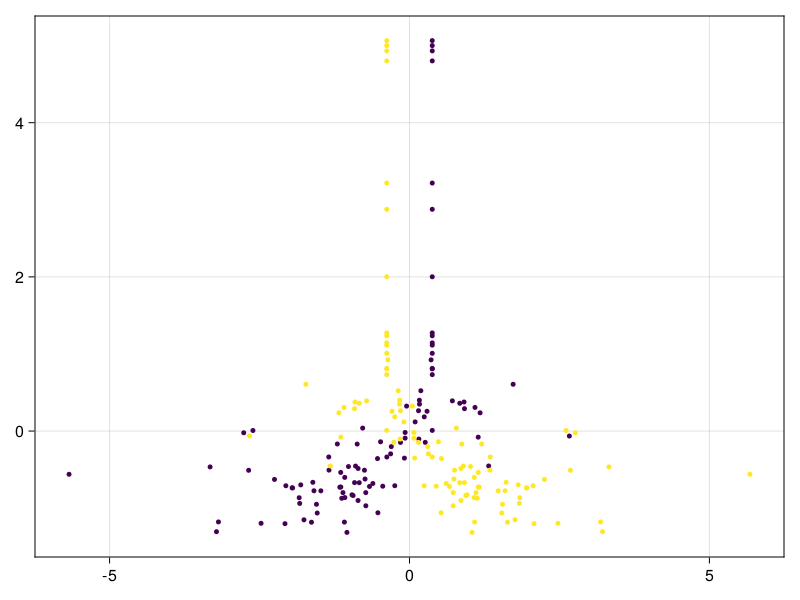

Predict:
K-means:


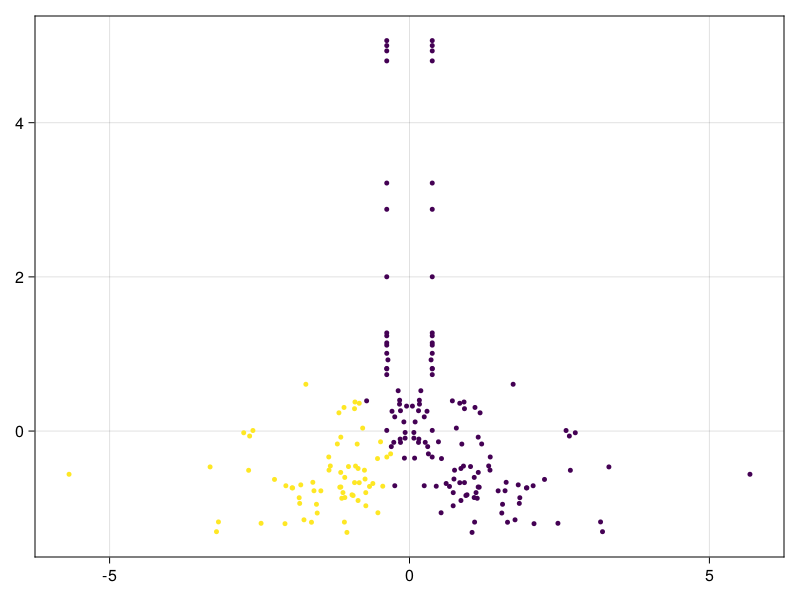

2×2 Matrix{Int64}:
 57  43
  9  91

0.74

GMM:
Posterior Probability:


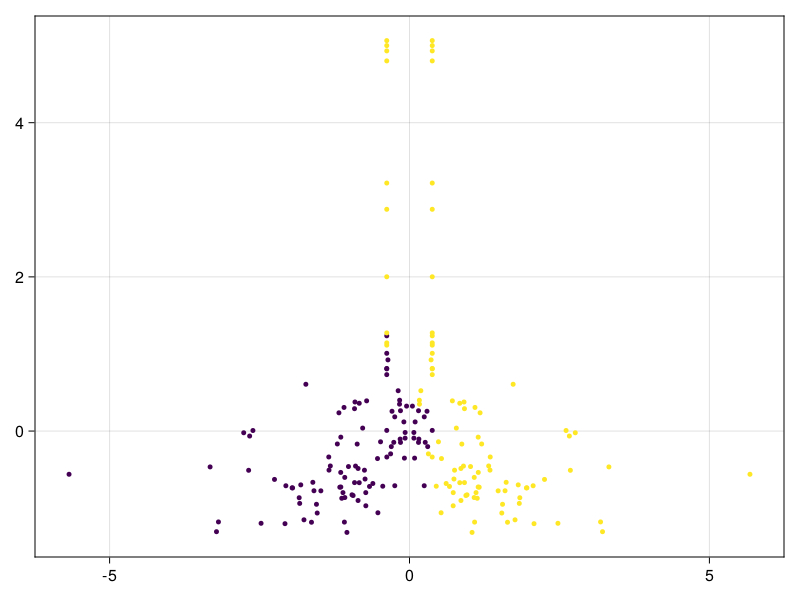

2×2 Matrix{Int64}:
 71  29
 33  67

0.69

Log Likelihood:


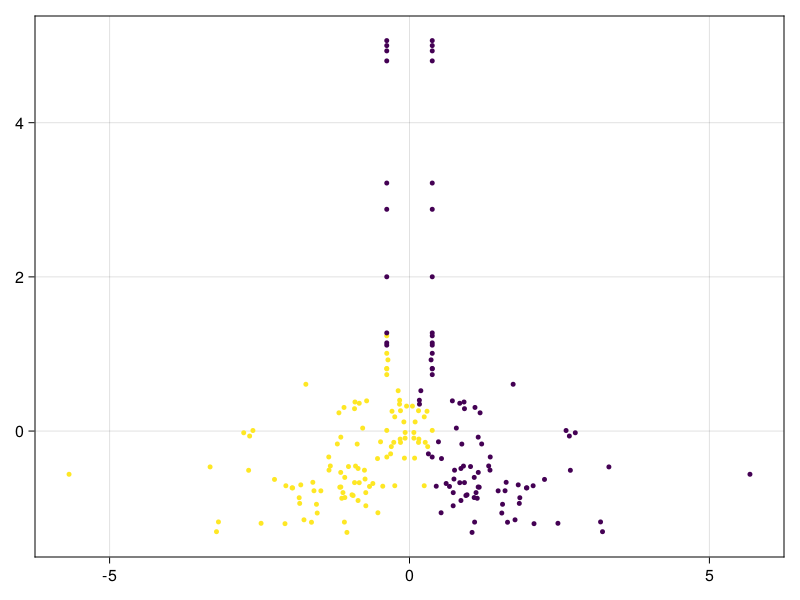

2×2 Matrix{Int64}:
 71  29
 33  67

0.69

Tree_1 and Tree_3
True:

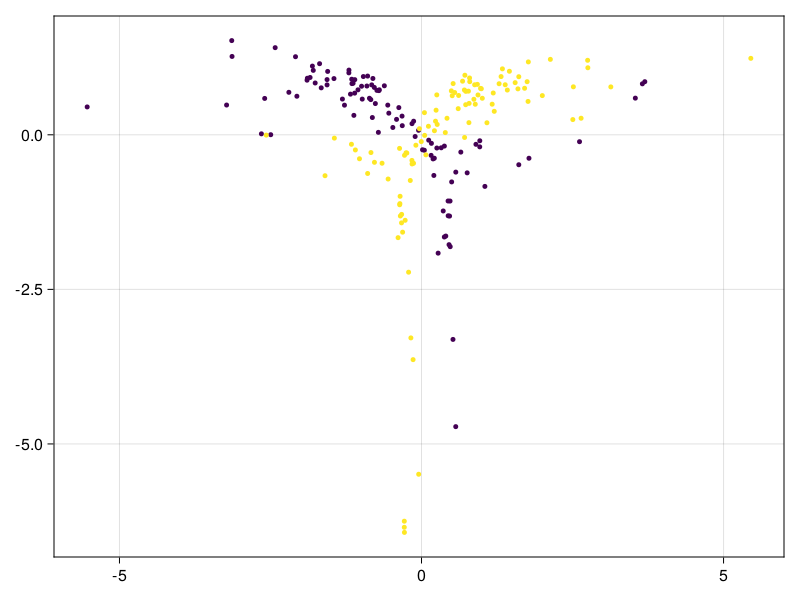

Predict:
K-means:


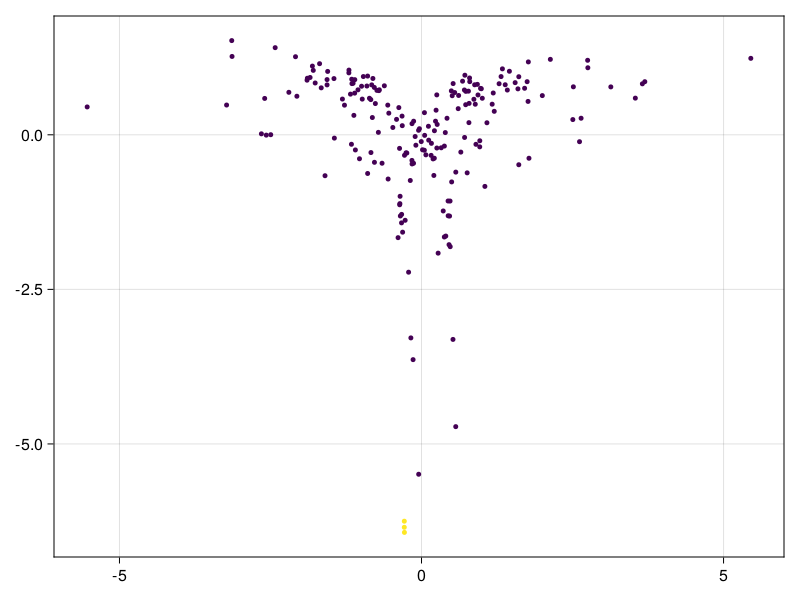

2×2 Matrix{Int64}:
 100  0
  97  3

0.515

GMM:
Posterior Probability:


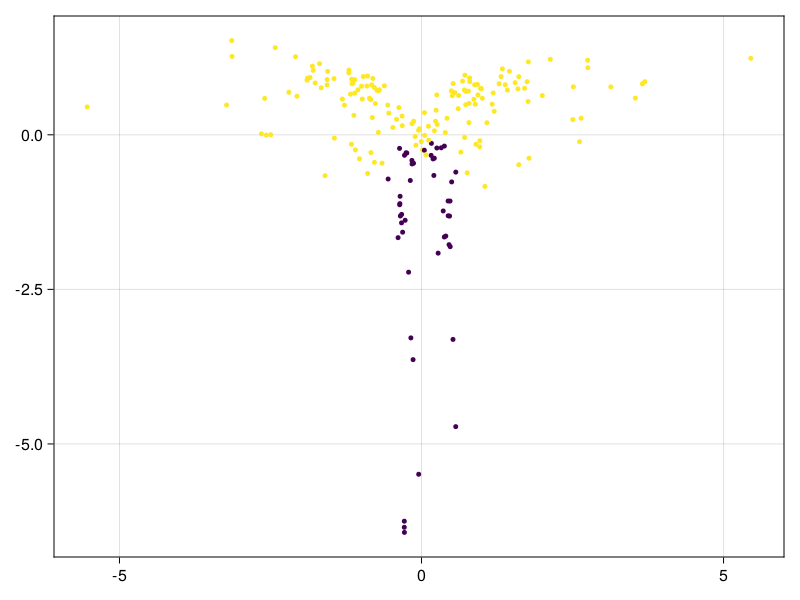

2×2 Matrix{Int64}:
 77  23
 75  25

0.51

Log Likelihood:


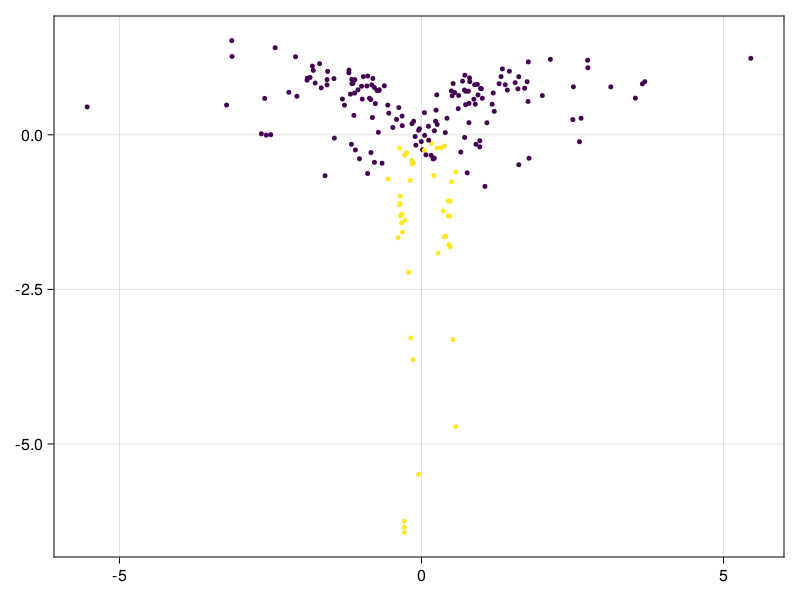

2×2 Matrix{Int64}:
 80  20
 75  25

0.525

Tree_1 and Tree_4
True:

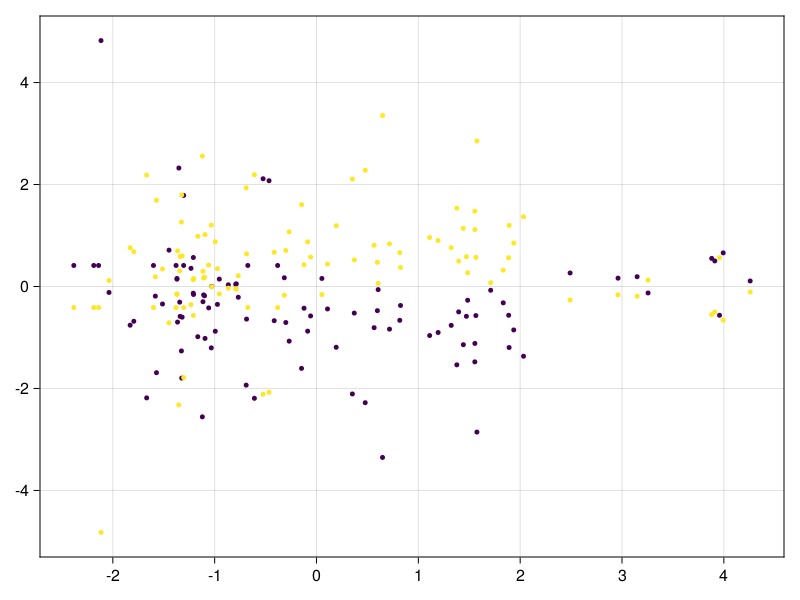

Predict:
K-means:


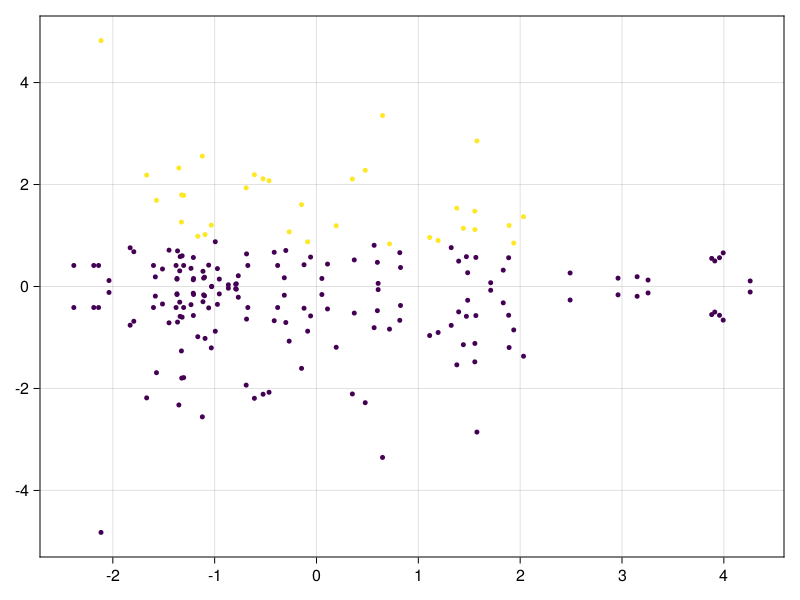

2×2 Matrix{Int64}:
 95   5
 72  28

0.615

GMM:
Posterior Probability:


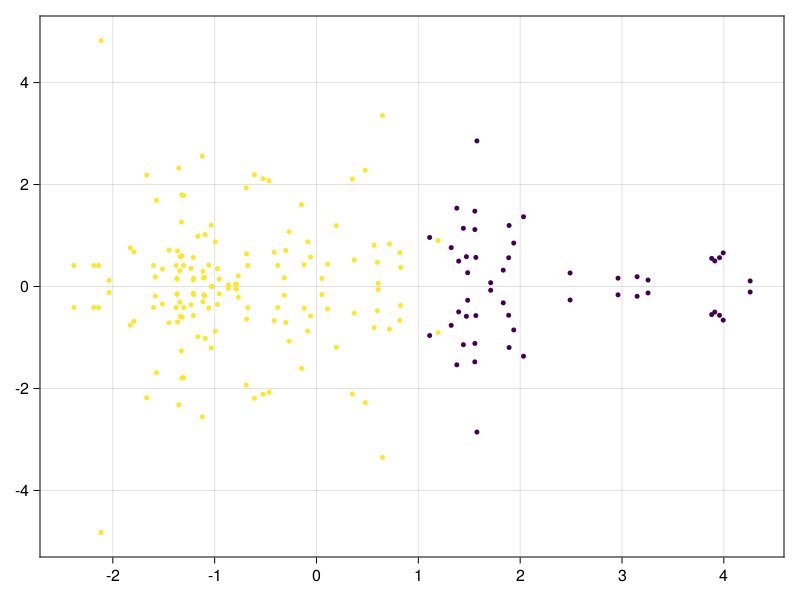

2×2 Matrix{Int64}:
 26  74
 26  74

0.5

Log Likelihood:


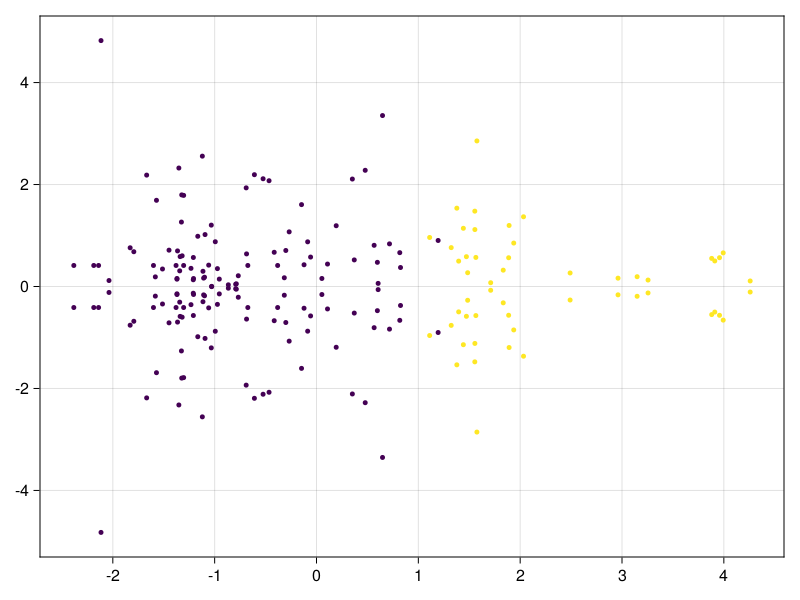

2×2 Matrix{Int64}:
 74  26
 74  26

0.5

Tree_1 and Tree_5
True:

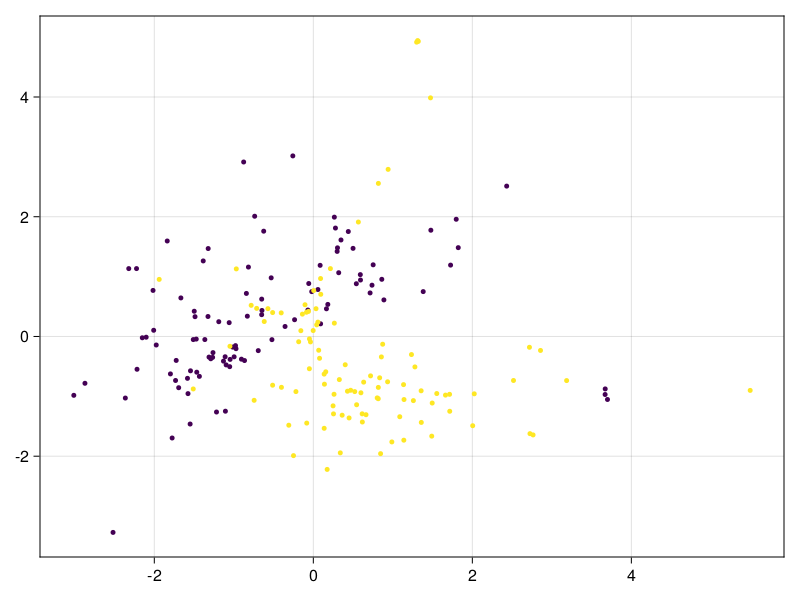

Predict:
K-means:


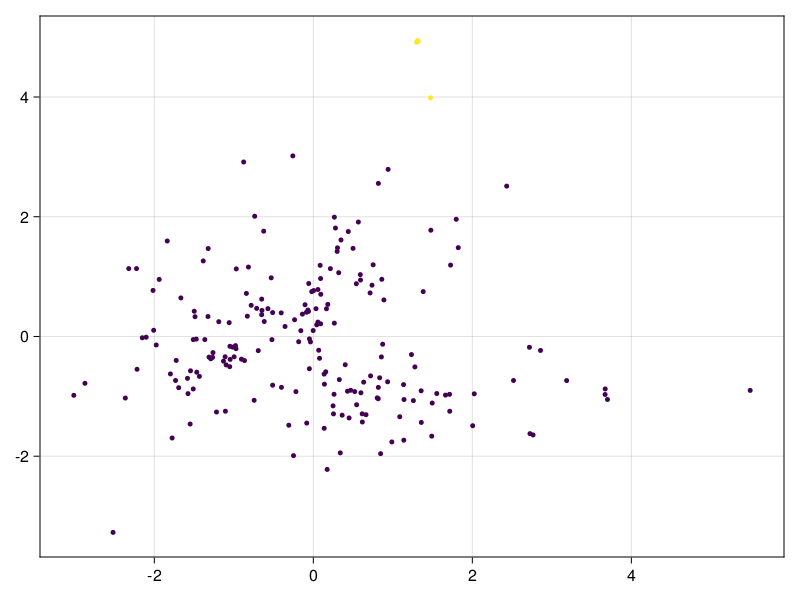

2×2 Matrix{Int64}:
 100  0
  96  4

0.52

GMM:
Posterior Probability:


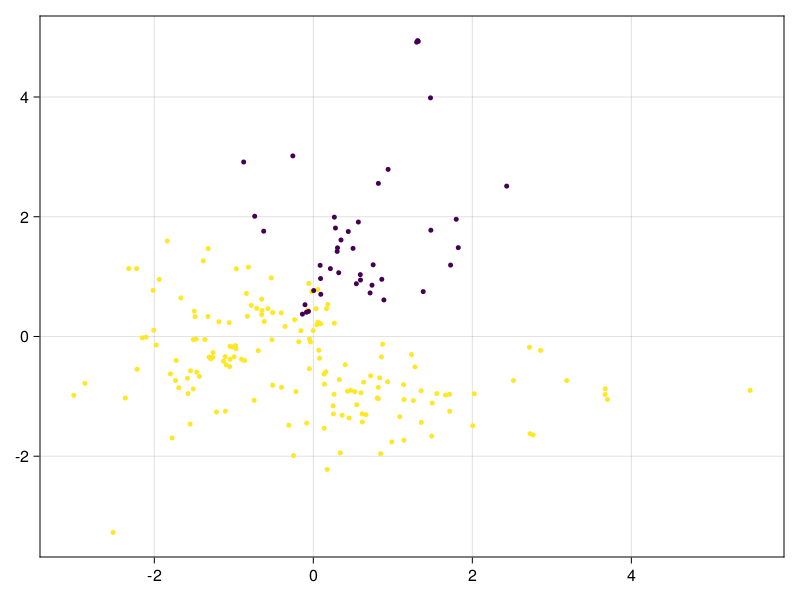

2×2 Matrix{Int64}:
 27  73
 15  85

0.56

Log Likelihood:


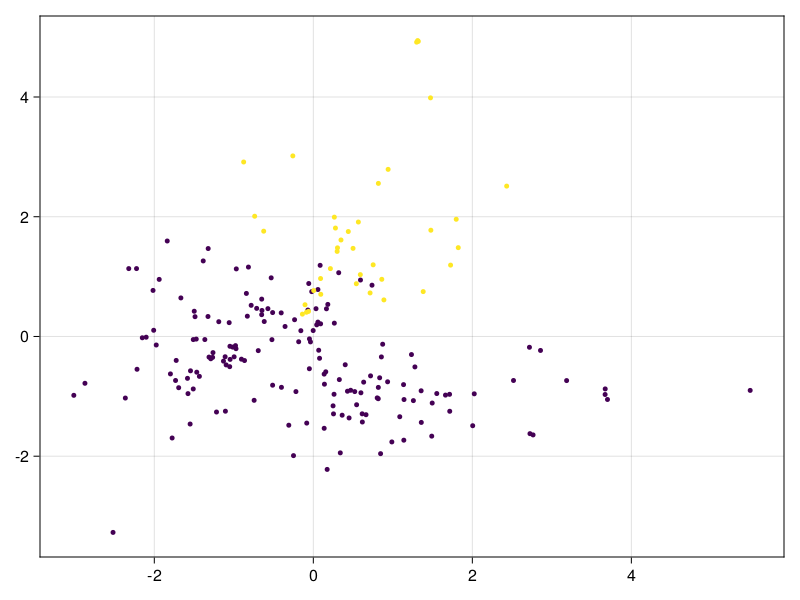

2×2 Matrix{Int64}:
 23  77
 15  85

0.54

Tree_1 and Tree_6
True:

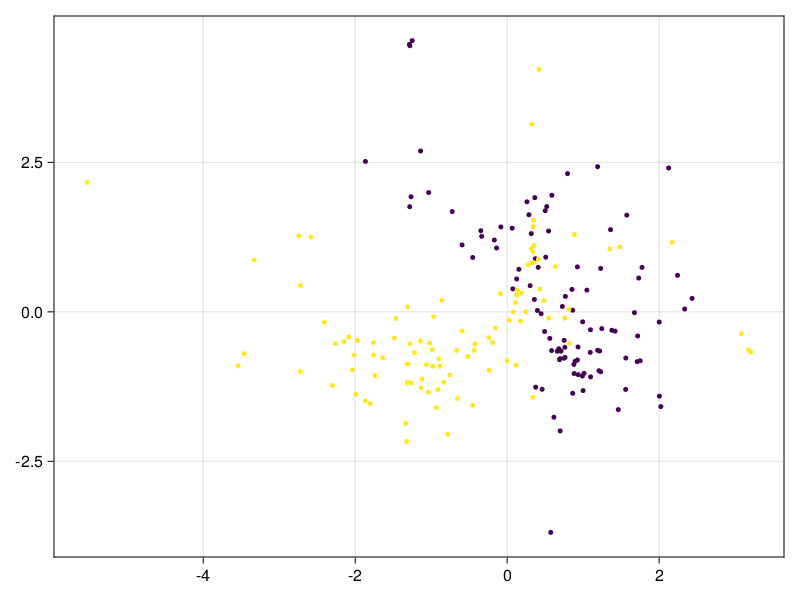

Predict:
K-means:


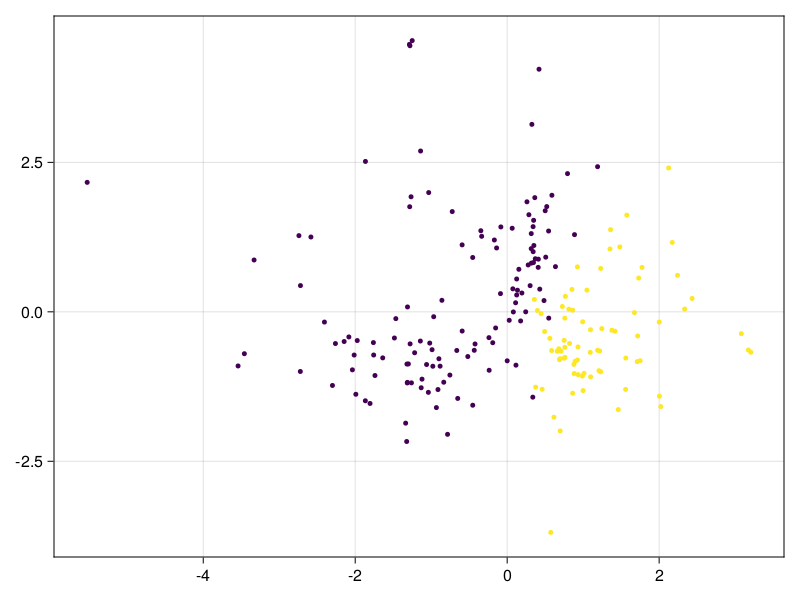

2×2 Matrix{Int64}:
 66  34
  9  91

0.785

GMM:
Posterior Probability:


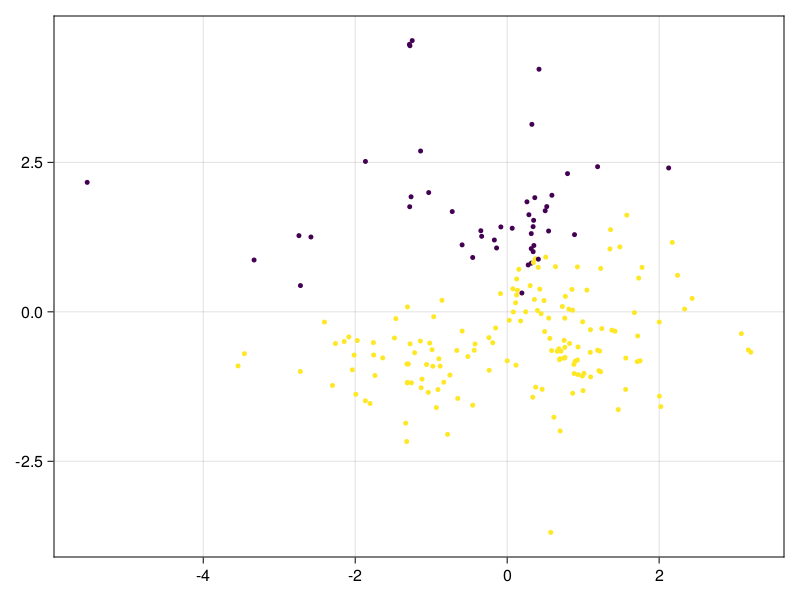

2×2 Matrix{Int64}:
 28  72
 17  83

0.555

Log Likelihood:


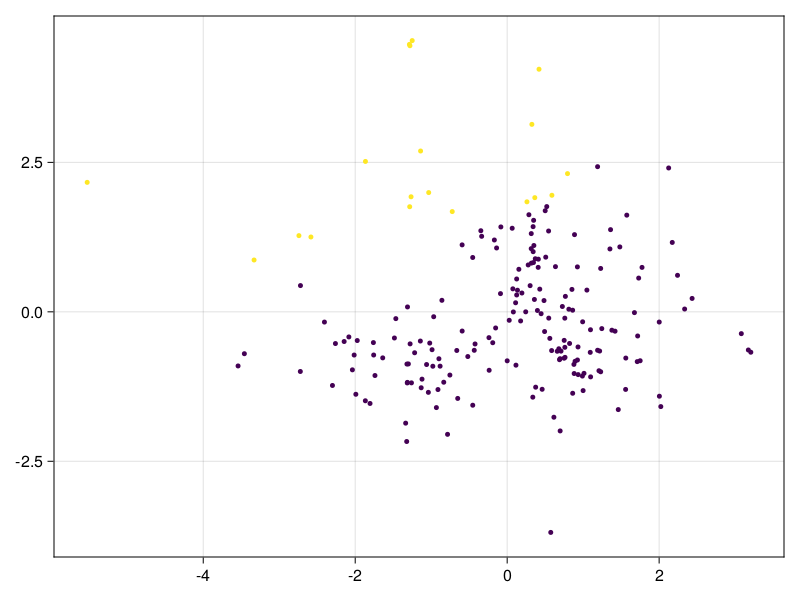

2×2 Matrix{Int64}:
 13  87
  6  94

0.535

Tree_1 and Tree_7
True:

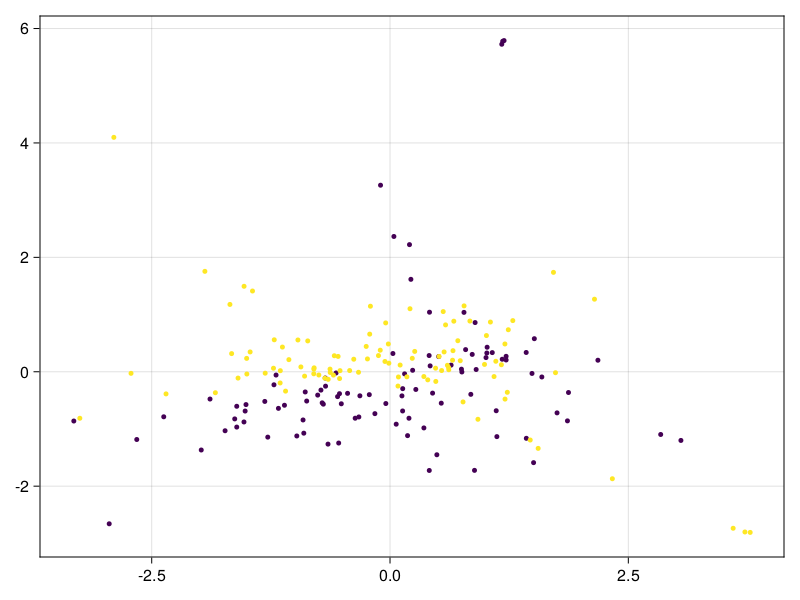

Predict:
K-means:


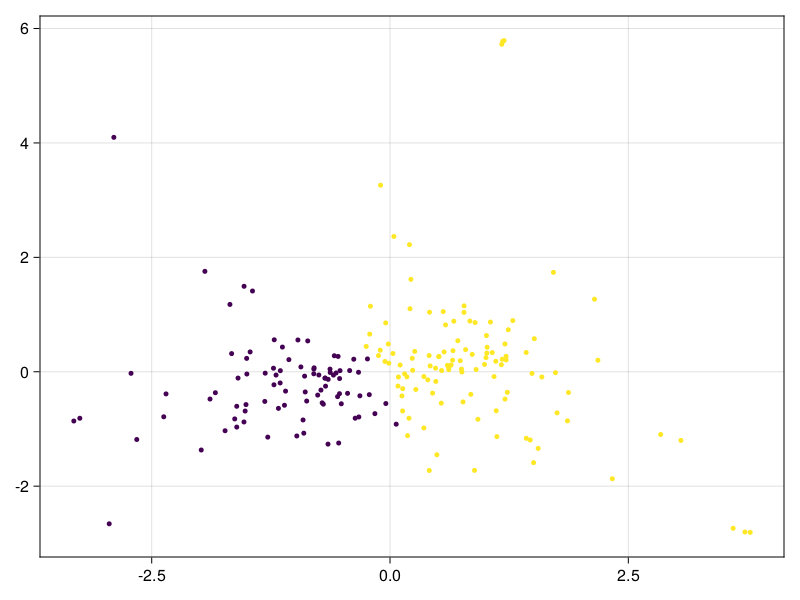

2×2 Matrix{Int64}:
 44  56
 43  57

0.505

GMM:
Posterior Probability:


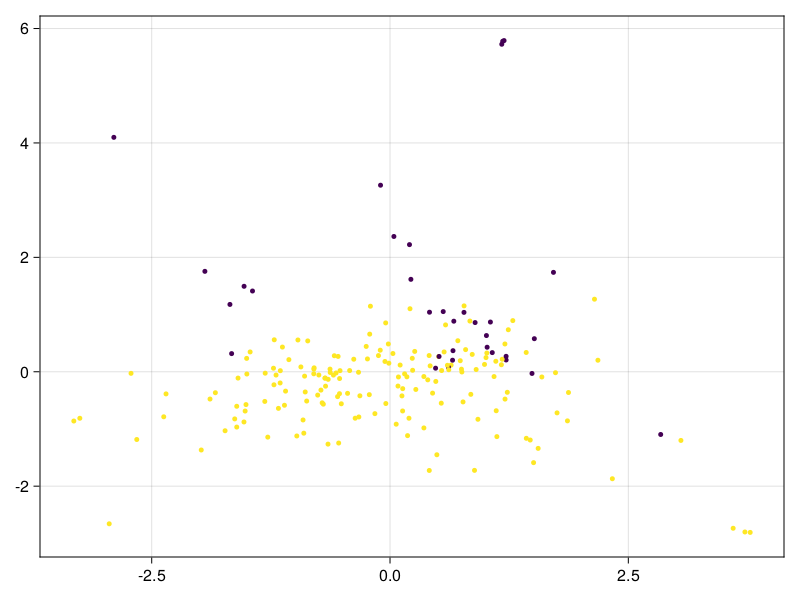

2×2 Matrix{Int64}:
 17  83
 16  84

0.505

Log Likelihood:


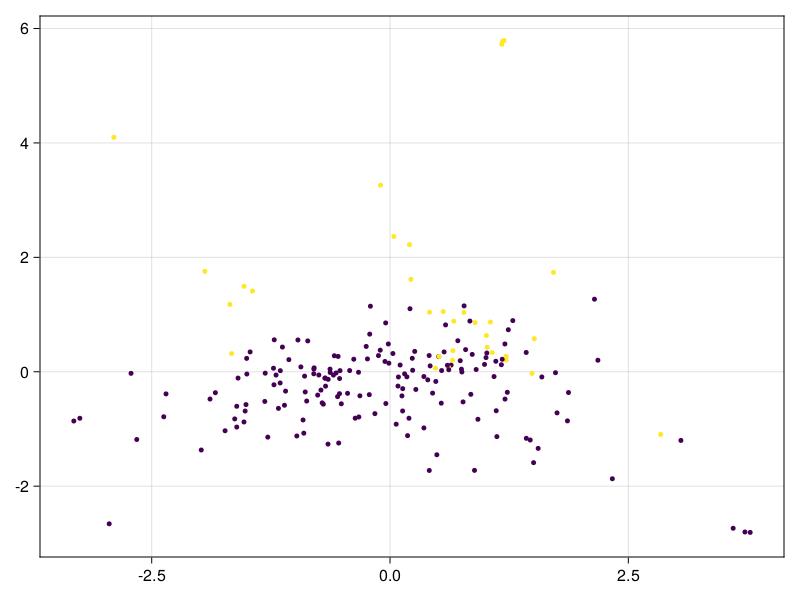

2×2 Matrix{Int64}:
 17  83
 16  84

0.505

Tree_1 and Tree_8
True:

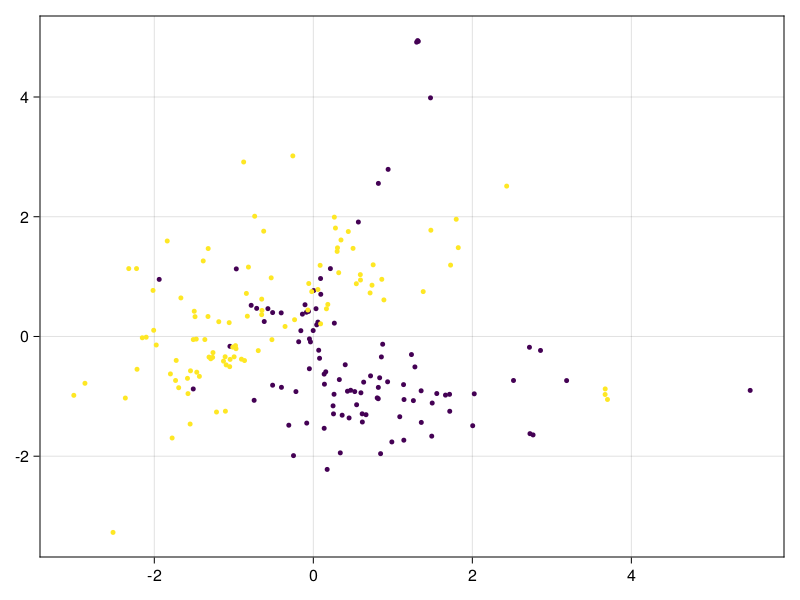

Predict:
K-means:


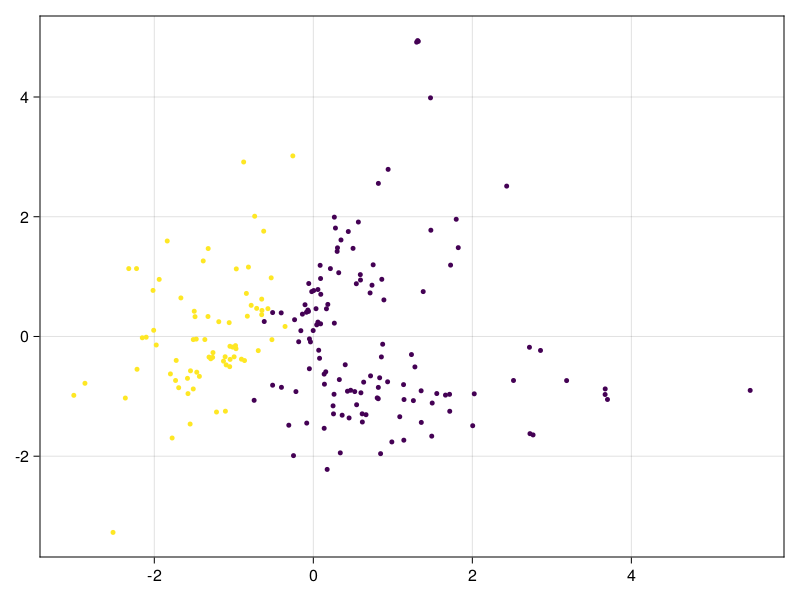

2×2 Matrix{Int64}:
 93   7
 34  66

0.795

GMM:
Posterior Probability:


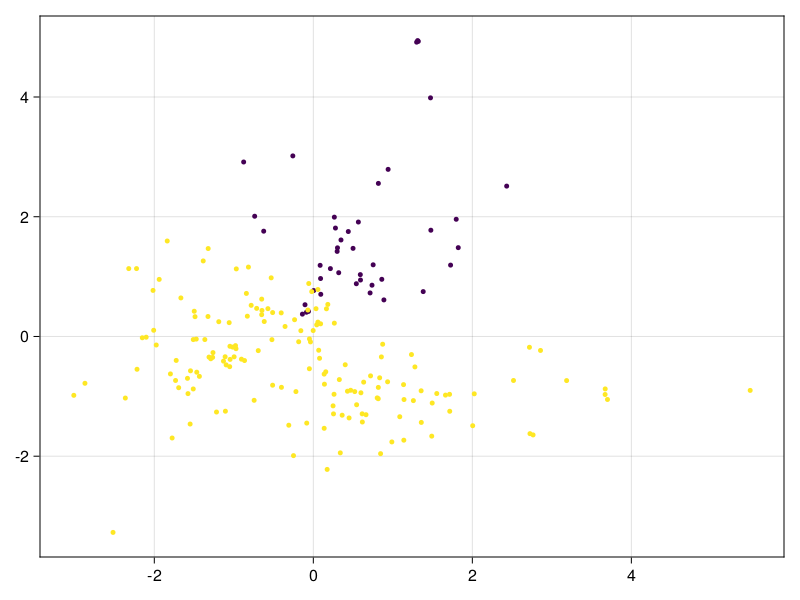

2×2 Matrix{Int64}:
 85  15
 73  27

0.56

Log Likelihood:


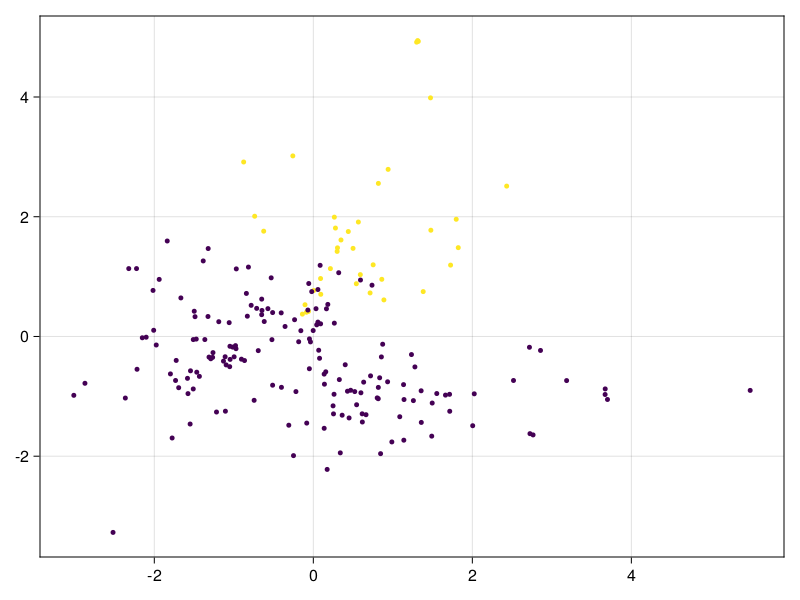

2×2 Matrix{Int64}:
 85  15
 77  23

0.54

Tree_1 and Tree_9
True:

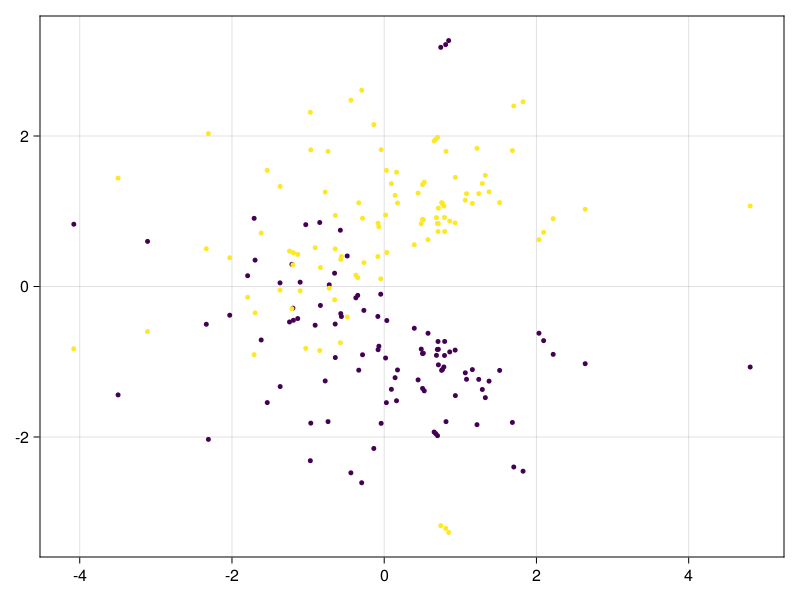

Predict:
K-means:


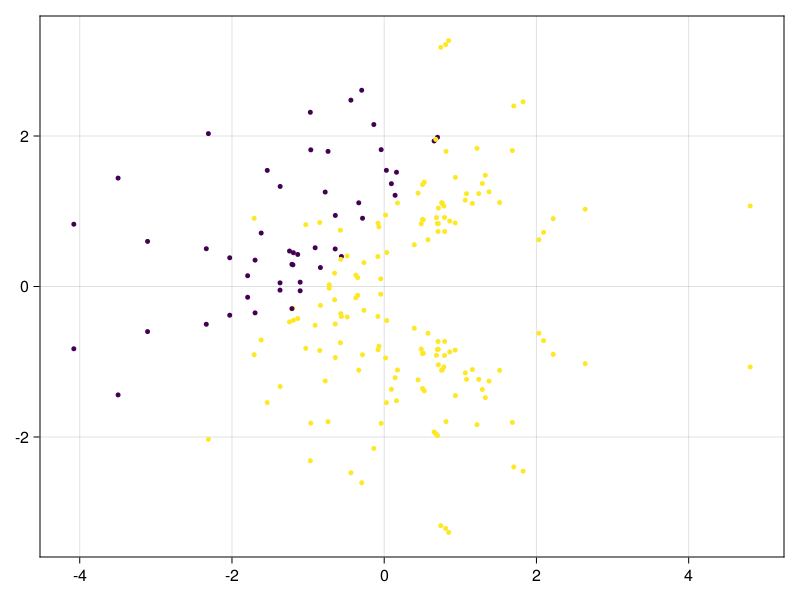

2×2 Matrix{Int64}:
 90  10
 61  39

0.645

GMM:
Posterior Probability:


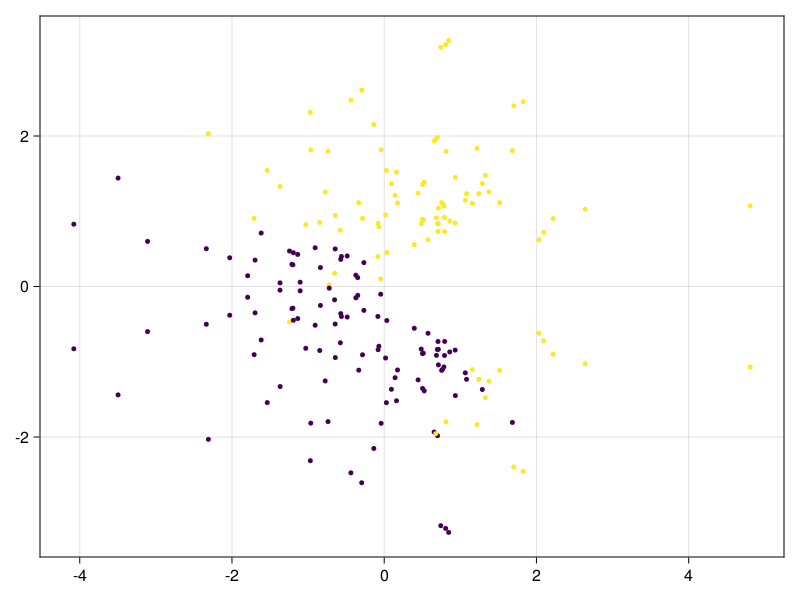

2×2 Matrix{Int64}:
 75  25
 33  67

0.71

Log Likelihood:


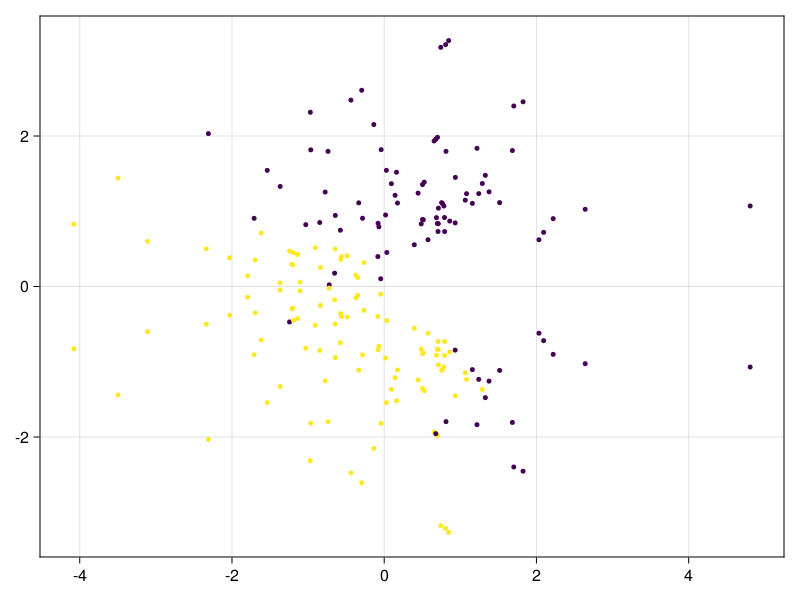

2×2 Matrix{Int64}:
 73  27
 33  67

0.7

Tree_1 and Tree_10
True:

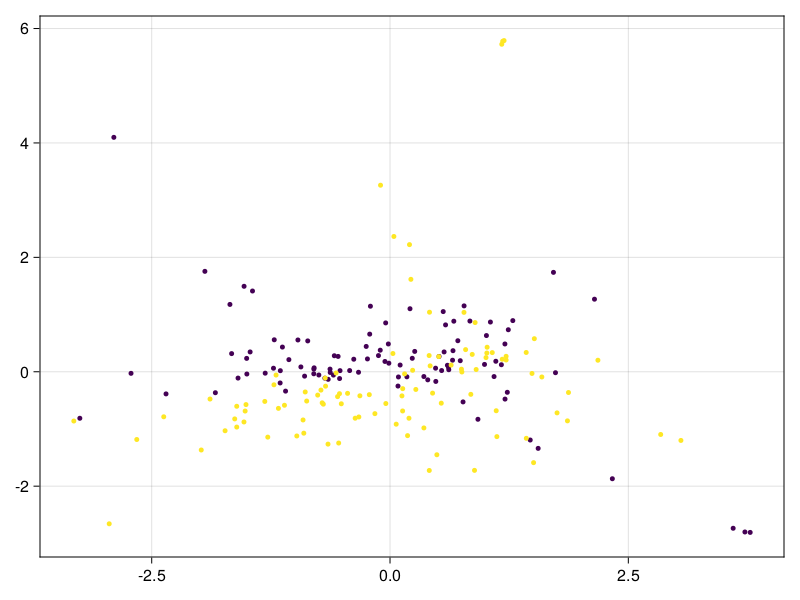

Predict:
K-means:


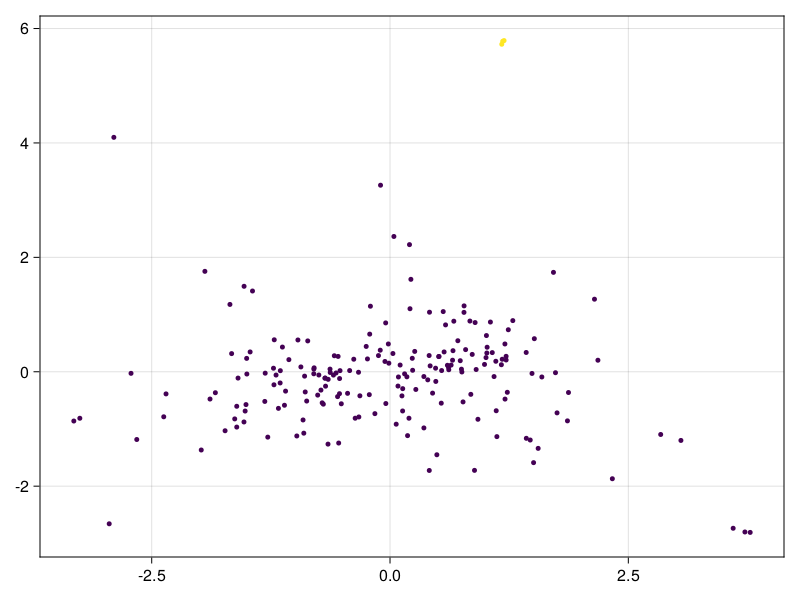

2×2 Matrix{Int64}:
 100  0
  97  3

0.515

GMM:
Posterior Probability:


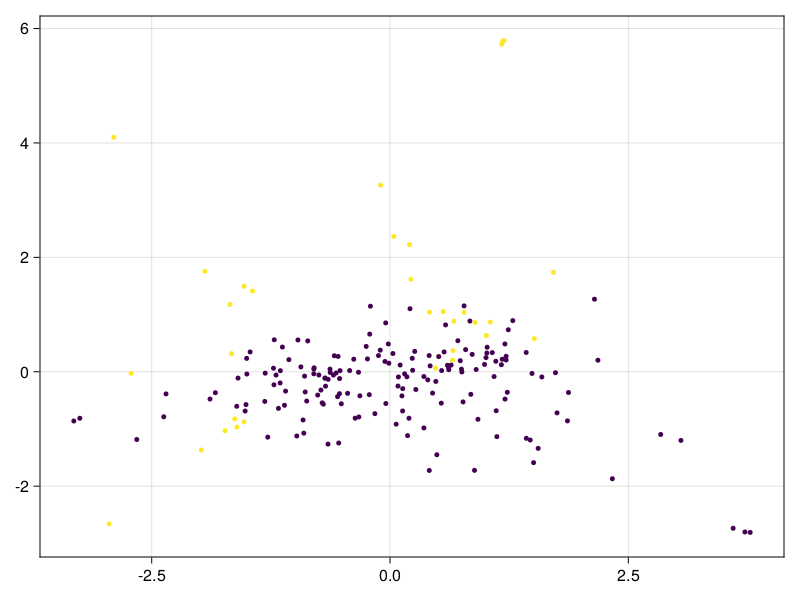

2×2 Matrix{Int64}:
 84  16
 83  17

0.505

Log Likelihood:


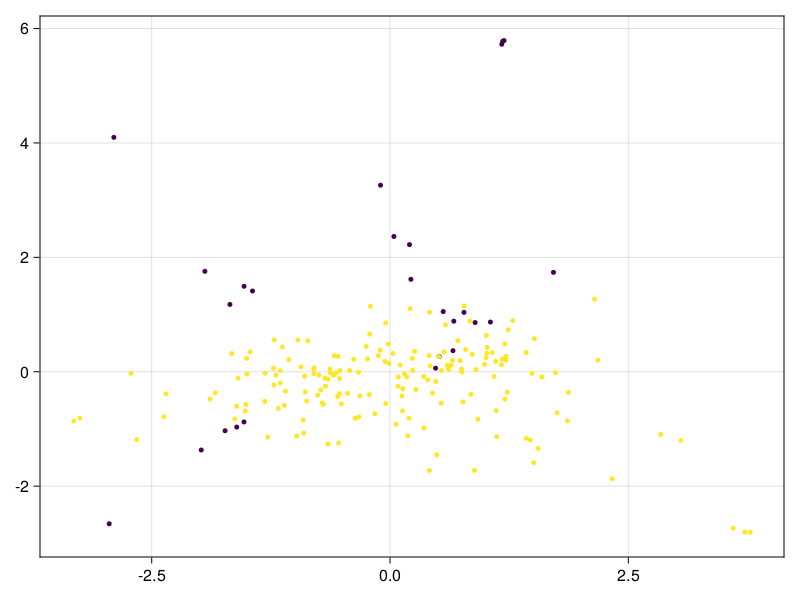

2×2 Matrix{Int64}:
 88  12
 86  14

0.51

Tree_1 and Tree_11
True:

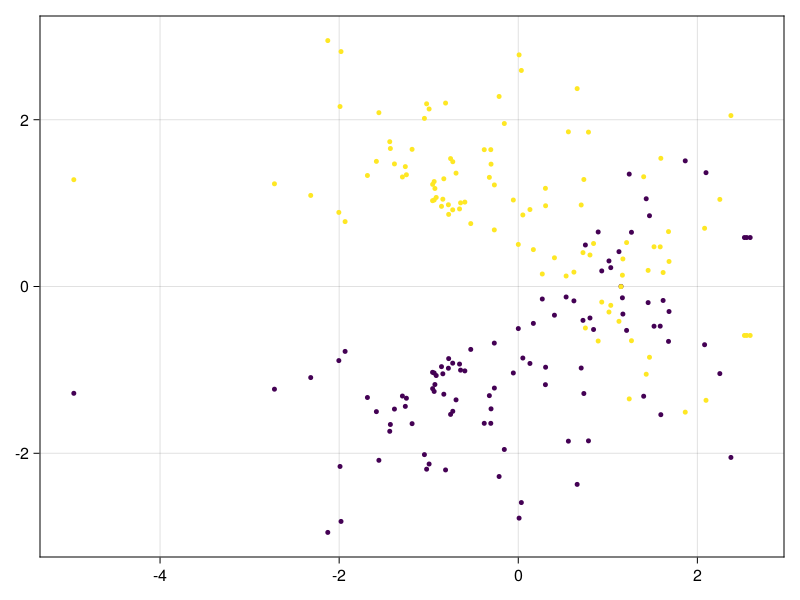

Predict:
K-means:


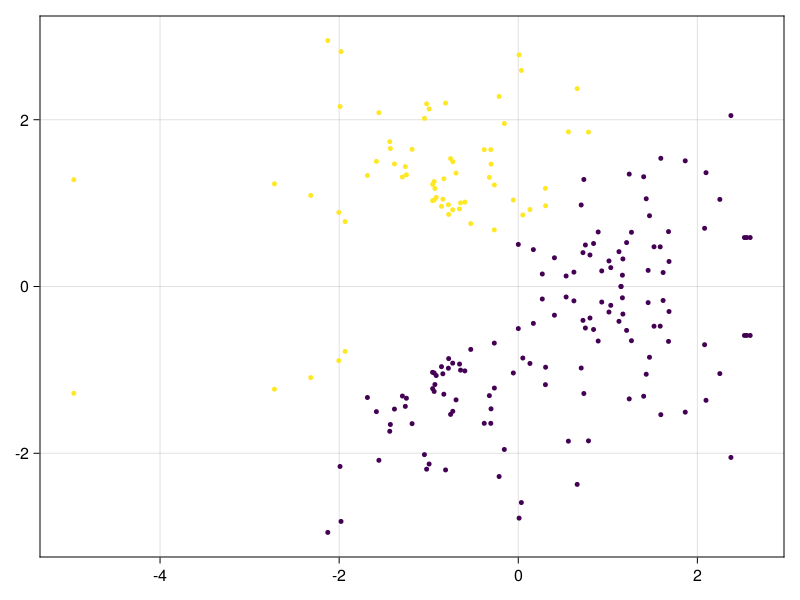

2×2 Matrix{Int64}:
 95   5
 41  59

0.77

GMM:
Posterior Probability:


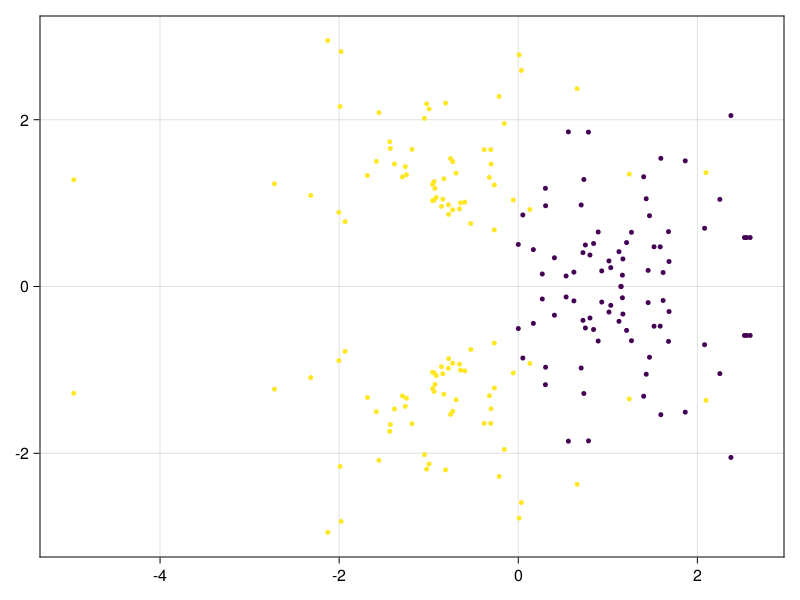

2×2 Matrix{Int64}:
 44  56
 44  56

0.5

Log Likelihood:


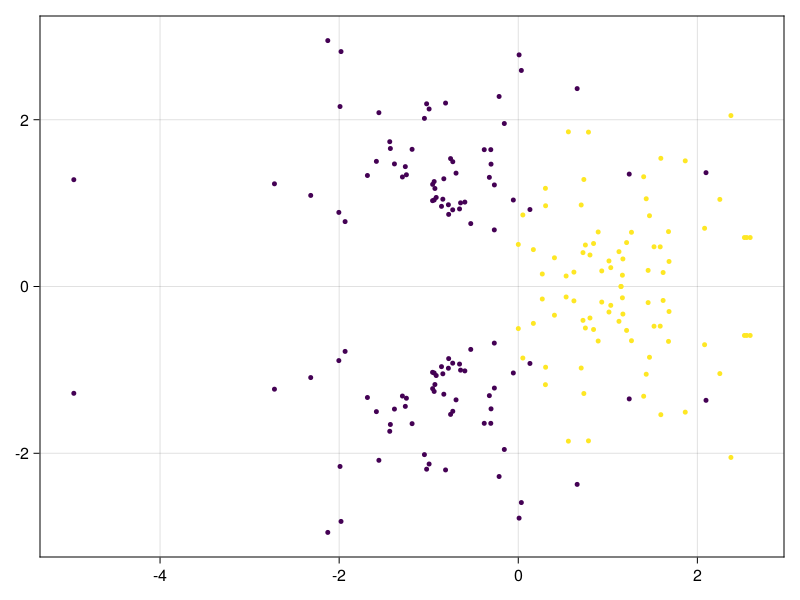

2×2 Matrix{Int64}:
 56  44
 56  44

0.5

Tree_1 and Tree_12
True:

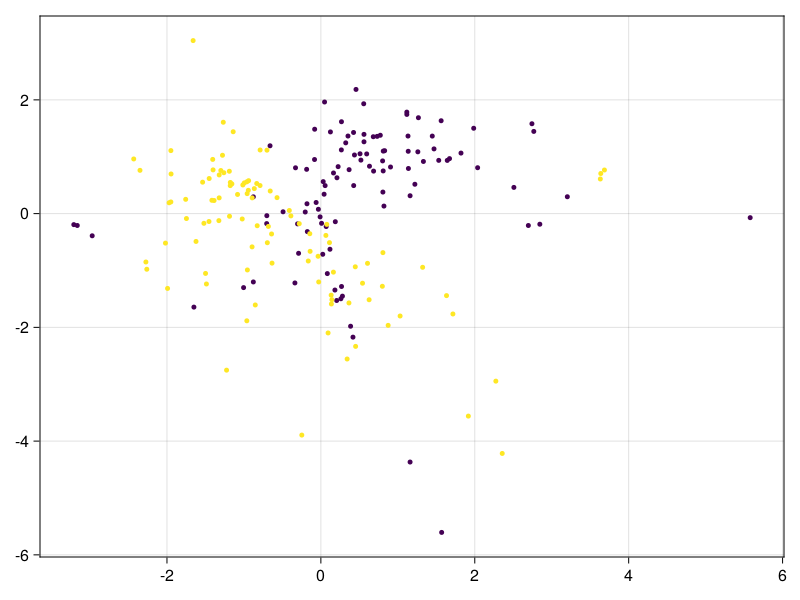

Predict:
K-means:


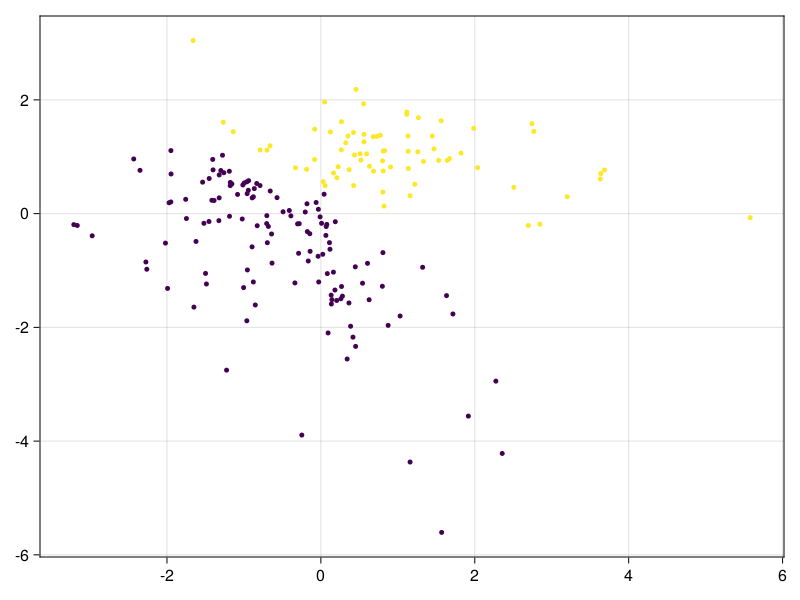

2×2 Matrix{Int64}:
 65  35
  8  92

0.785

GMM:
Posterior Probability:


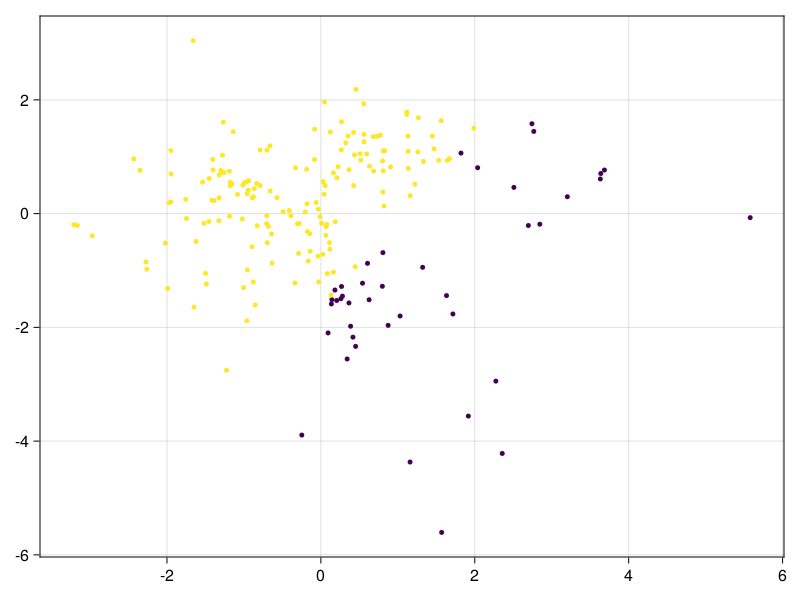

2×2 Matrix{Int64}:
 82  18
 77  23

0.525

Log Likelihood:


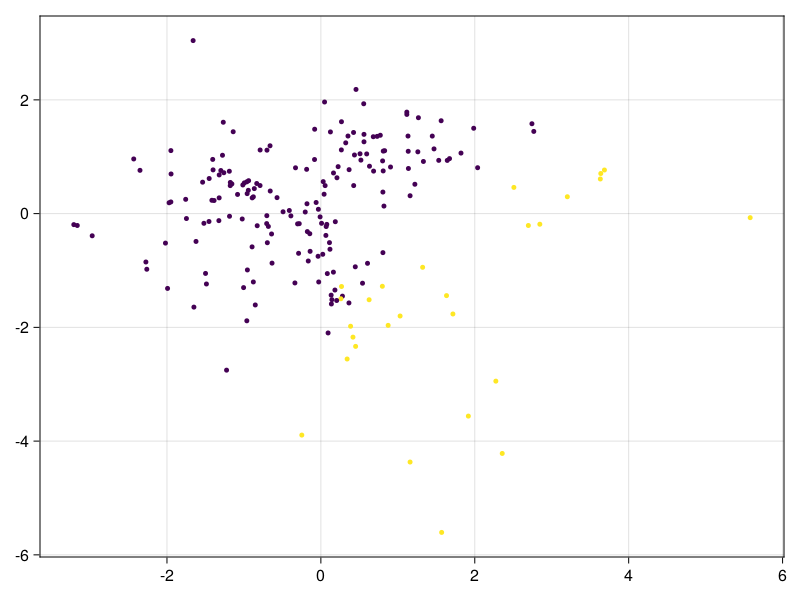

2×2 Matrix{Int64}:
 89  11
 84  16

0.525

Tree_1 and Tree_13
True:

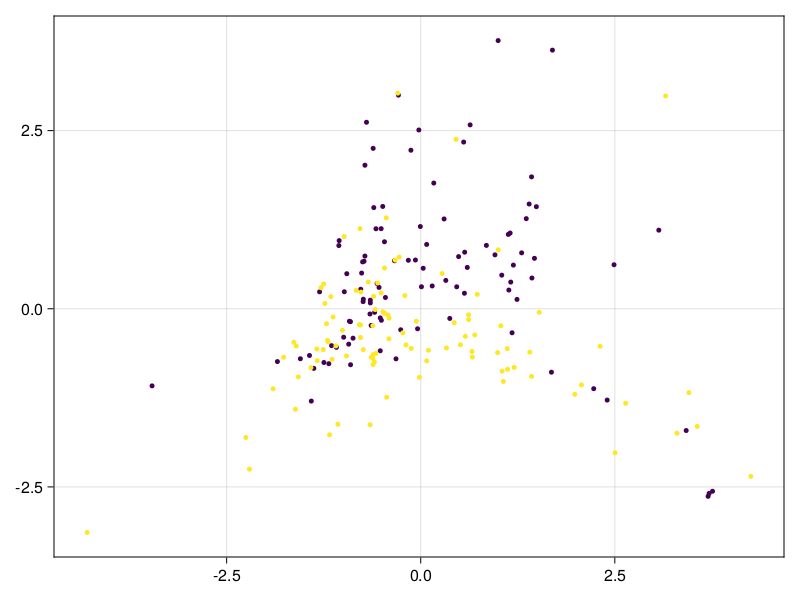

Predict:
K-means:


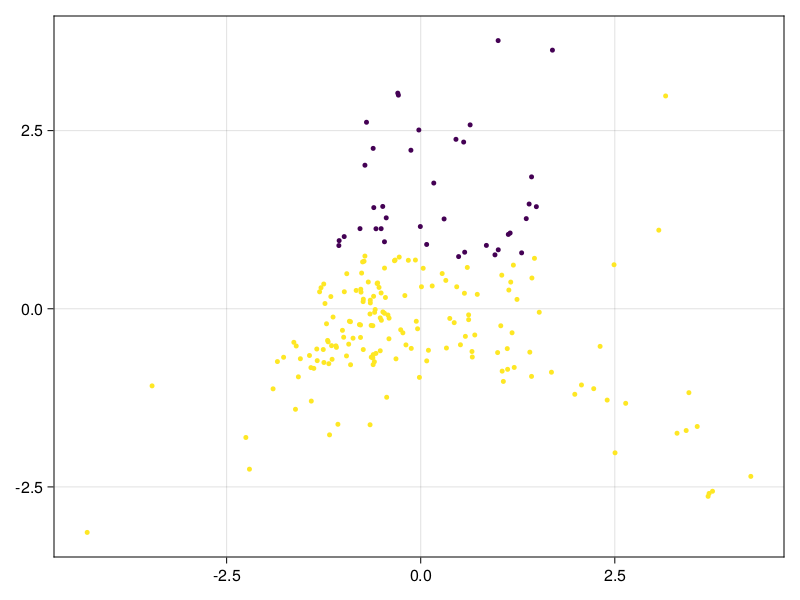

2×2 Matrix{Int64}:
 32  68
  6  94

0.63

GMM:
Posterior Probability:


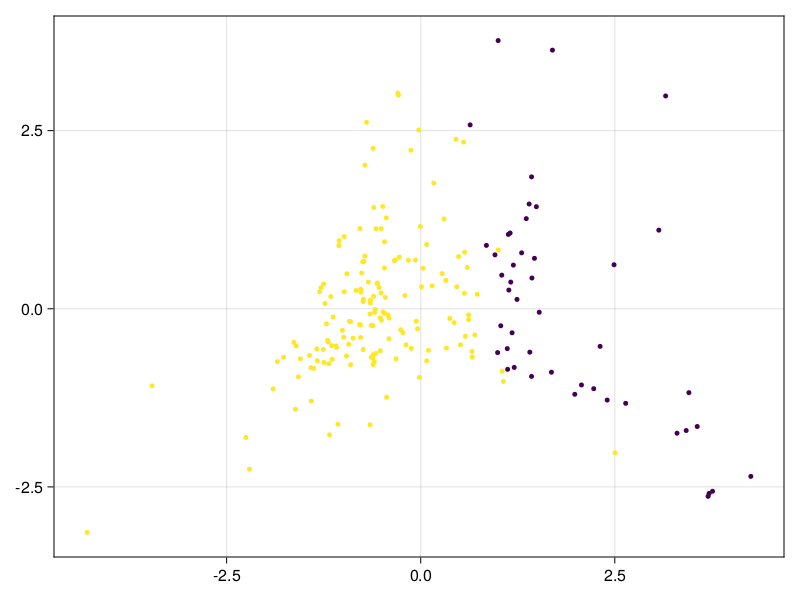

2×2 Matrix{Int64}:
 29  71
 17  83

0.56

Log Likelihood:


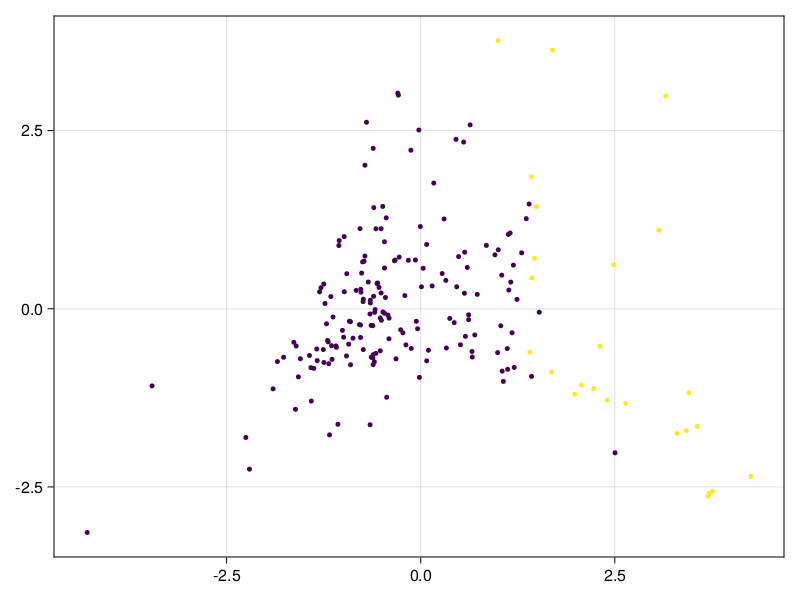

2×2 Matrix{Int64}:
 15  85
 10  90

0.525

Tree_1 and Tree_14
True:

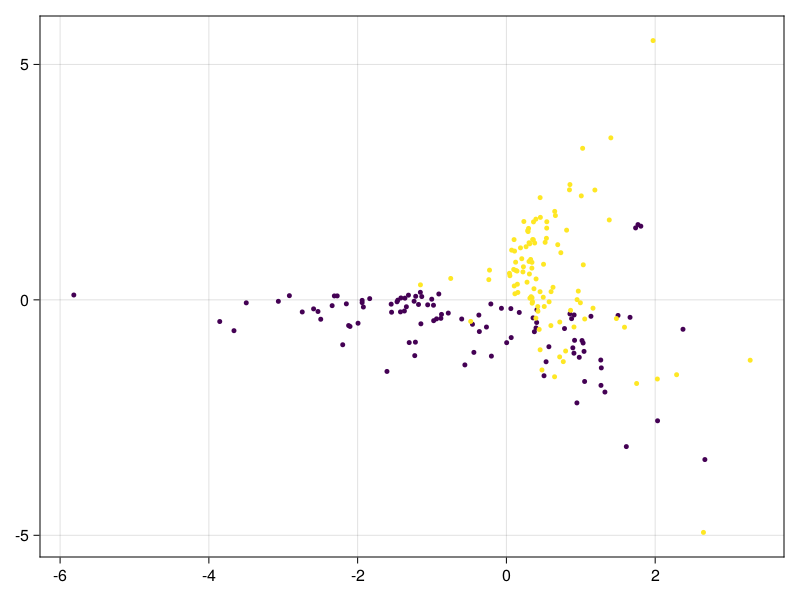

Predict:
K-means:


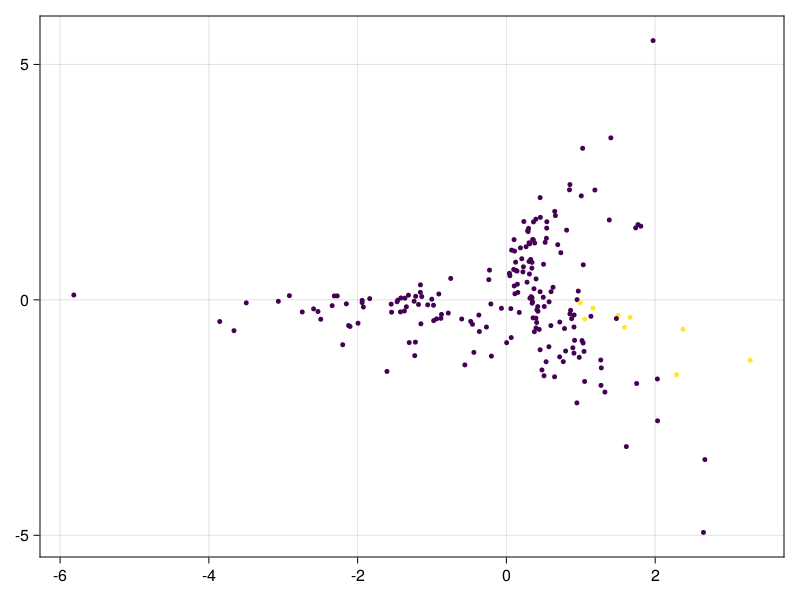

2×2 Matrix{Int64}:
 97  3
 94  6

0.515

GMM:
Posterior Probability:


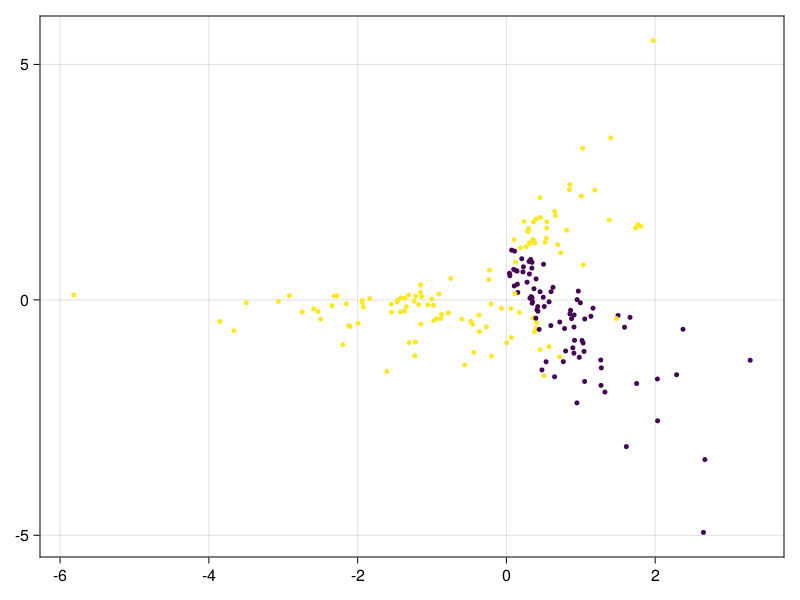

2×2 Matrix{Int64}:
 74  26
 44  56

0.65

Log Likelihood:


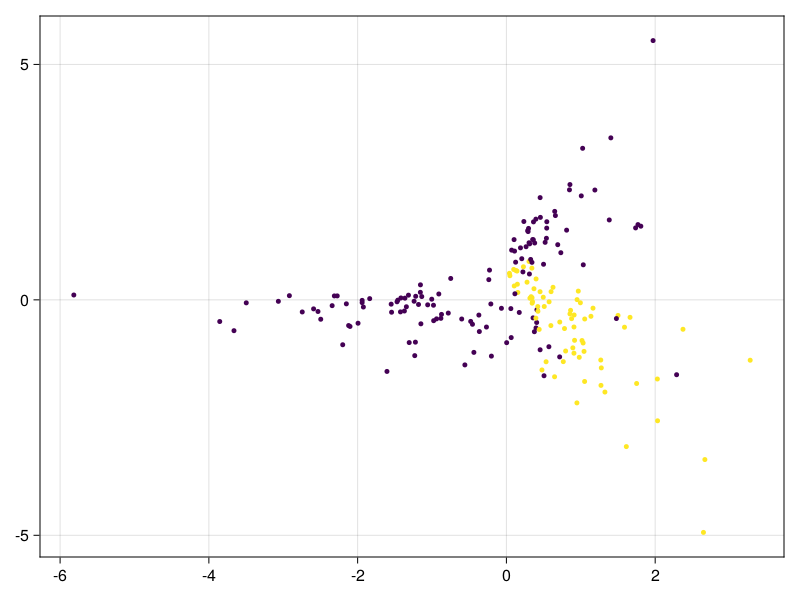

2×2 Matrix{Int64}:
 75  25
 53  47

0.61

Tree_1 and Tree_15
True:

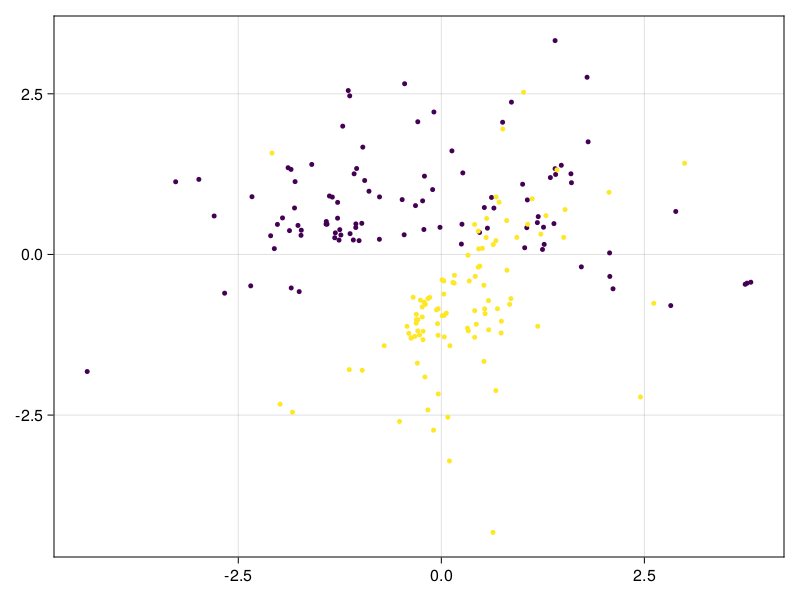

Predict:
K-means:


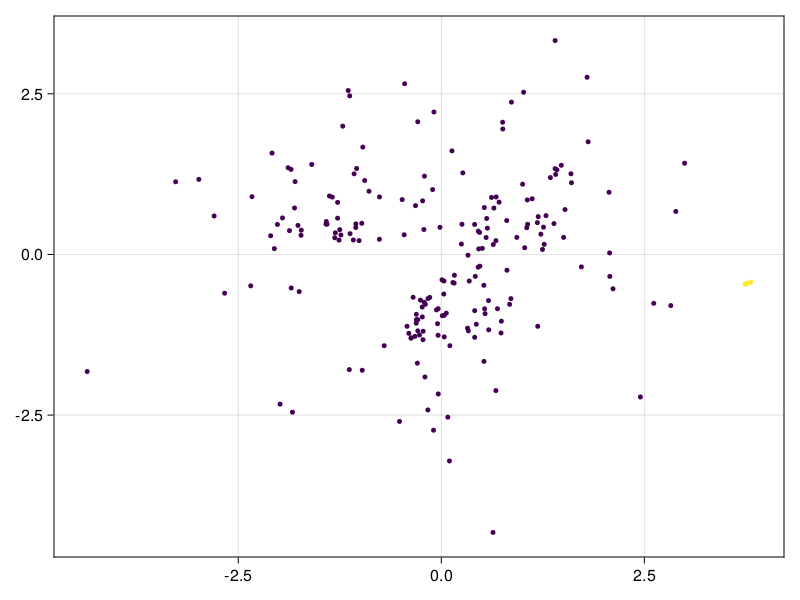

2×2 Matrix{Int64}:
 3   97
 0  100

0.515

GMM:
Posterior Probability:


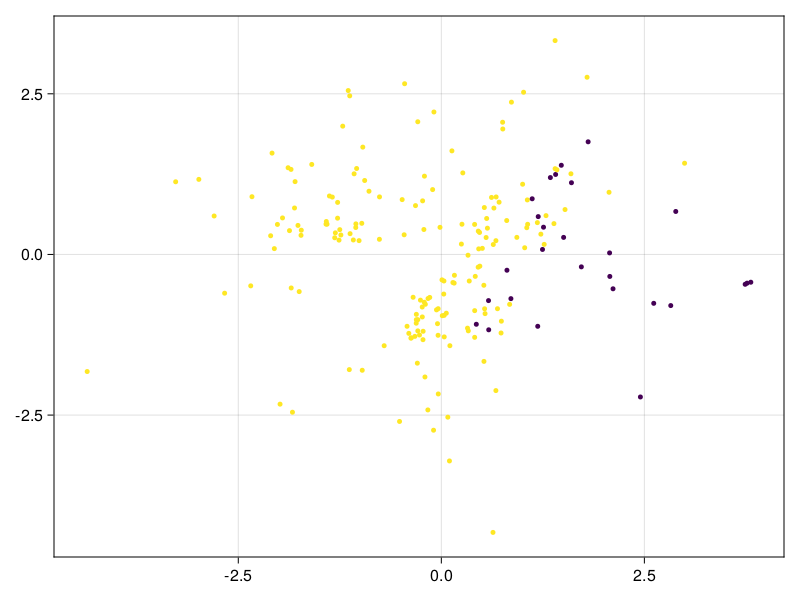

2×2 Matrix{Int64}:
 17  83
 10  90

0.535

Log Likelihood:


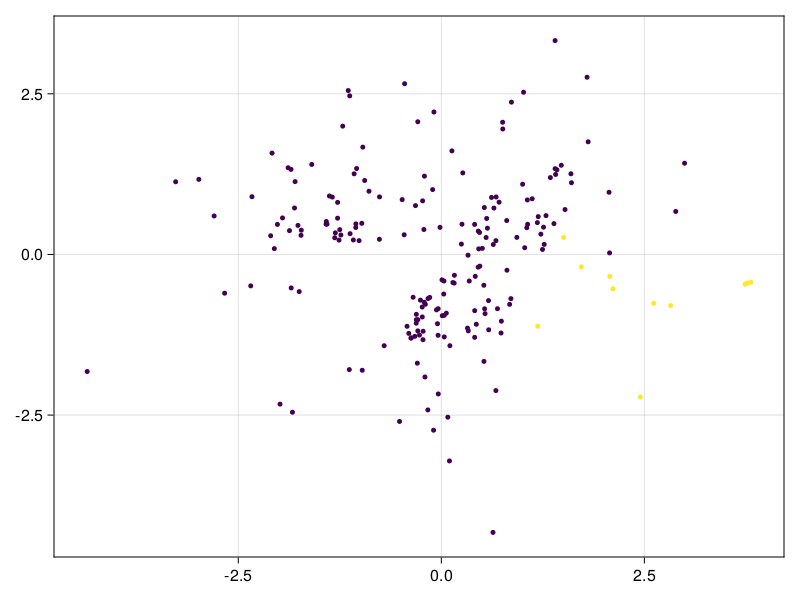

2×2 Matrix{Int64}:
 7  93
 4  96

0.515



In [26]:
list_check(trees, 1)